# 5.2.4 API / Scraping

## Challenge

Do a little scraping or API-calling of your own.  Pick a new website and see what you can get out of it.  Expect that you'll run into bugs and blind alleys, and rely on your mentor to help you get through.  

Formally, your goal is to write a scraper that will:

1) Return specific pieces of information (rather than just downloading a whole page)  
2) Iterate over multiple pages/queries  
3) Save the data to your computer  

Once you have your data, compute some statistical summaries and/or visualizations that give you some new insights into your scraping topic of interest.  Write up a report from scraping code to summary and share it with your mentor.

In [1]:
# a helper function

my_string = "blahblah=14"

import re

def get_num(a_string):
    
    m = re.search("\d", a_string)
    return a_string[m.start():]

print(get_num(my_string))


14


In [2]:
import scrapy
from scrapy.crawler import CrawlerProcess

class ESSpider(scrapy.Spider):
    # Naming the spider is important if you are running more than one spider of
    # this class simultaneously.
    name = "ESS"
    
    # URL(s) to start with.
    start_urls = [
        'https://portland.craigslist.org/d/jobs/search/jjj',
    ]

    # Use XPath to parse the response we get.
    def parse(self, response):
        
        # Iterate over every word class element on the page.
        response.selector.remove_namespaces()
        
        for article in response.xpath('//li[@class="result-row"]'): 
     
                # Yield a dictionary with the values we want.
                yield {
                    'date': article.xpath('*/time/@datetime').extract(), # this worked as //time
                    'job': article.xpath('*/a[@class="result-title hdrlnk"]/text()').extract(), # also worked as //a
                    'location': article.xpath('p/span/span[@class="result-hood"]/text()').extract(),
                }
            # Get the URL of the next page.
        next_page = response.xpath('//div/div/span/a[@class="button next"]/@href').extract_first()
        
        #print(get_num(next_page))  # this was just a double check to make sure it was running
        
        # there are 119 results on each page, so the url next_page ends in a multiple of 120
        # since we don't want to go beyond page 9 let's calc 120 x 9
        
        maximum  = 9 * 120  
        
        # Recursively call the spider to run on the next page, if it exists.
        if next_page is not None and int(get_num(next_page)) < maximum:
            next_page = response.urljoin(next_page)
            # Request the next page and recursively parse it the same way we did above
            yield scrapy.Request(next_page, callback=self.parse)

# Tell the script how to run the crawler by passing in settings.
# The new settings have to do with scraping etiquette.          
process = CrawlerProcess({
    'FEED_FORMAT': 'json',         # Store data in JSON format.
    'FEED_URI': 'data3.json',       # Name our storage file.
    'LOG_ENABLED': False,          # Turn off logging for now.
    'ROBOTSTXT_OBEY': True,
    'USER_AGENT': 'ThinkfulDataScienceBootcampCrawler (thinkful.com)',
    'AUTOTHROTTLE_ENABLED': True,
    'HTTPCACHE_ENABLED': True
})

# Start the crawler with our spider.
process.crawl(ESSpider)
process.start()
print('Success!')

Success!


In [3]:
import pandas as pd

# Checking whether we got data from all 9 pages
ESSdf = pd.read_json('data3.json', orient='records')
print(ESSdf.shape)
print(ESSdf.head())

(1080, 3)
                 date                                                job  \
0  [2018-10-05 21:46]                            [Bartender at Taphouse]   
1  [2018-10-05 20:36]  [►MAKE UP TO $25/HOUR ON YOUR OWN SCHEDULE /W ...   
2  [2018-10-05 20:34]                                [EXTRA CASH DRIVER]   
3  [2018-10-05 20:14]     [Recptionist/Optical assistant for Eye Clinic]   
4  [2018-10-05 20:11]                        [Legal Secretary/Assistant]   

                  location  
0  [ (9230 SW Burnham St)]  
1                       []  
2        [ (VANCOUVER,WA)]  
3           [ (Milwaukie)]  
4            [ (Downtown)]  


We have a little bit of a mess here. Cleaning up the data a little bit...

First, it looks like each cell is a 1 item list, so I'm going to fix it so each cell is just the item itself, not the list. <br />
I used [this resource](https://chrisalbon.com/python/data_wrangling/pandas_expand_cells_containing_lists/).


In [4]:
for col in ESSdf.columns:
    # separate the list into columns (in this case, 1 each)
    temporary = ESSdf[col].apply(pd.Series)
    ESSdf[col] = temporary


Next, a little bit more cleaning, so we can actually analyze the data.

In [5]:
# convert the date to datetime format

ESSdf['date'] = pd.to_datetime(ESSdf['date'], infer_datetime_format=True, errors="ignore")

# take out the time
ESSdf['time posted'] = ESSdf['date'].dt.time

#also take out the date
ESSdf['date posted'] = ESSdf['date'].dt.date

In [6]:
# clean up the job titles a tiny bit

# make everything lowercase
ESSdf['job'] = ESSdf['job'].str.lower()

# get rid of some special characters
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

ESSdf['job'] = ESSdf['job'].apply(text_cleaner)

In [7]:
# reorder the columns 
cols = ['date', 'date posted', 'time posted', 'location', 'job']

jobs = ESSdf[cols]

In [8]:
jobs.head()

,date,date posted,time posted,location,job
0,2018-10-05 21:46:00,2018-10-05,21:46:00,(9230 SW Burnham St),bartender at taphouse
1,2018-10-05 20:36:00,2018-10-05,20:36:00,NaN,►make up to $25/hour on your own schedule /w p...
2,2018-10-05 20:34:00,2018-10-05,20:34:00,"(VANCOUVER,WA)",extra cash driver
3,2018-10-05 20:14:00,2018-10-05,20:14:00,(Milwaukie),recptionist/optical assistant for eye clinic
4,2018-10-05 20:11:00,2018-10-05,20:11:00,(Downtown),legal secretary/assistant


Let's take a look at which days the postings are from.

In [9]:
jobs['day'] = jobs['date'].dt.day

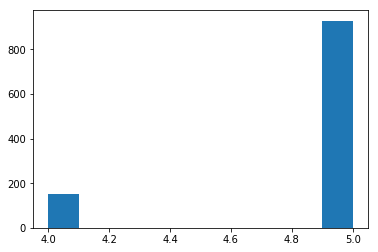

In [18]:
import matplotlib.pyplot as plt

plt.hist(jobs['day'])
plt.show()

It looks like they are all from just 2 days, most of which from one. Let's look at the job titles instead, and get a list of the most common job topics using some NLP techniques.

In [11]:
import spacy

nlp = spacy.load('en_core_web_lg')

jobs['parsed'] = jobs['job'].apply(nlp)

In [12]:
from collections import Counter

def bag_of_words(text, all_words):
    
    # Filter out punctuation and stop words.
    all_words += ([token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop])
    
    # Return the most common words.
    return [item[0] for item in Counter(all_words).most_common(1000)]
    
all_words = []
jobs['parsed'].apply(bag_of_words, args=(all_words,))

common_words = [item[0] for item in Counter(all_words).most_common(150)]

Let's take a look at the most common words and then move on to getting the main topics.

In [13]:
common_words[:20]

['$',
 'time',
 'driver',
 'hire',
 'to',
 'part',
 'need',
 'assistant',
 'be',
 'for',
 'and',
 'a',
 '-PRON-',
 'make',
 'cdl',
 'in',
 'bonus',
 'want',
 'full',
 'warehouse']

In [14]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
topic_paras_tfidf=vectorizer.fit_transform(all_words)

# Getting the word list.
terms = vectorizer.get_feature_names()

In [15]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

svd= TruncatedSVD(3)
lsa = make_pipeline(svd, Normalizer(copy=False))
topic_paras_lsa = lsa.fit_transform(topic_paras_tfidf)

components_lsa = word_topic(topic_paras_tfidf, topic_paras_lsa, terms)

In [16]:
top_words(components_lsa, 5)

0         time 128.0
0        bonus 25.22
0    associate 24.47
0     portland 21.37
0         auto 12.85
1       driver 105.0
1          make 48.4
1        night 45.14
1         pron 43.53
1          cdl 38.82
2          hire 90.0
2         need 75.07
2            hr 48.5
2        amazon 47.5
2         sale 39.11
dtype: object

In this case, the most common words for the most part overlapped completely with the main topics. It is probably because of the very small text sample size and the lack of context. 
